In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt

stock=input("Enter a stock ticker symbol: ")
print(stock)

startyear=2017
startmonth=1
startday=1

start=dt.datetime(startyear,startmonth,startday)

now=dt.datetime.now()

df=yf.download(stock,start,now)

matype="smooth"
shortTermMas = [50]
longTermMas = [200]
masUsed=shortTermMas+longTermMas
shortTermMasCols = []
longTermMasCols = []
for x in shortTermMas:
    if matype=="smooth":
        sma=x
        col="Sma_"+str(sma)
        df[col]=round(df.iloc[:,4].rolling(window=sma).mean(),2)
        shortTermMasCols.append(col)
    elif matype=="exponential":
        ema=x
        col="Ema_"+str(ema)
        df[col]=round(df.iloc[:,4].ewm(span=ema, adjust=False).mean(),2)
        shortTermMasCols.append(col)

for x in longTermMas:
    if matype=="smooth":
        sma=x
        col="Sma_"+str(sma)
        df[col]=round(df.iloc[:,4].rolling(window=sma).mean(),2)
        longTermMasCols.append(col)
    elif matype=="exponential":
        ema=x
        col="Ema_"+str(ema)
        df[col]=round(df.iloc[:,4].ewm(span=ema, adjust=False).mean(),2)
        longTermMasCols.append(col)

df=df.iloc[max(longTermMas):] # limit dataframe to first point max MA is calculated

pos=0
num=0
percentchange=[]

for i in df.index:
    
    cmin=df.iloc[num][shortTermMasCols].min()
    cmax=df.iloc[num][longTermMasCols].min()

    close=df["Adj Close"][i]
    if num<len(df)-1:
        next_open=df.iloc[num+1]["Open"] # opportunity to buy or sell will be at the next open price
    
    if(cmin>cmax):
        if(pos==0):
            bp=next_open
            pos=1

    elif(cmin<cmax):
        if(pos==1):
            pos=0
            sp=next_open
            pc=(sp/bp-1)*100
            percentchange.append(pc)

    if(num==df["Adj Close"].count()-1 and pos==1):
        pos=0
        sp=close
        pc=(sp/bp-1)*100
        percentchange.append(pc)

    num+=1

gains=0
ng=0
losses=0
nl=0
totalR=1

for i in percentchange:
    if(i>0):
        gains+=i
        ng+=1
    else:
        losses+=i
        nl+=1
    totalR=totalR*((i/100)+1)

totalR=round((totalR-1)*100,2)

if(ng>0):
    avgGain=gains/ng
    maxR=str(round(max(percentchange),2))+"%"
else:
    avgGain=0
    maxR="undefined"

if(nl>0):
    avgLoss=losses/nl
    maxL=str(round(min(percentchange),2))+"%"
    ratio=str(round(-avgGain/avgLoss,2))
else:
    avgLoss=0
    maxL="undefined"
    ratio="inf"

if(ng>0 or nl>0):
    battingAvg=ng/(ng+nl)
else:
    battingAvg=0

print()
print("Results for "+stock+" from "+str(df.index[0].date())+" to "+str(df.index[-1].date()))
print("Sample size: "+str(ng+nl)+" trades over "+str((df.index[-1]-df.index[0]).days)+" days")
print("EMAs used: "+str(masUsed))
print("Win Rate: "+ str(round(battingAvg,2))+"%")
print("Gain/loss ratio: "+ratio)
print("Average Gain: "+str(round(avgGain,2))+"%")
print("Average Loss: "+str(round(avgLoss,2))+"%")
print("Max Return: "+maxR+"%")
print("Max Loss: "+ maxL+"%")
print("Total return over "+str(ng+nl)+ " trades: "+str(totalR)+"%")
print()
print("Total return buy-and-hold: "+str(round((df.iloc[-1,4]/df.iloc[0,4] - 1)*100,2))+"%")

Enter a stock ticker symbol: SPY
SPY
[*********************100%***********************]  1 of 1 completed

Results for SPY from 2017-10-18 to 2020-12-04
Sample size: 3 trades over 1143 days
EMAs used: [50, 200]
Win Rate: 0.67%
Gain/loss ratio: 0.93
Average Gain: 10.93%
Average Loss: -11.79%
Max Return: 17.27%%
Max Loss: -11.79%%
Total return over 3 trades: 8.2%

Total return buy-and-hold: 53.1%


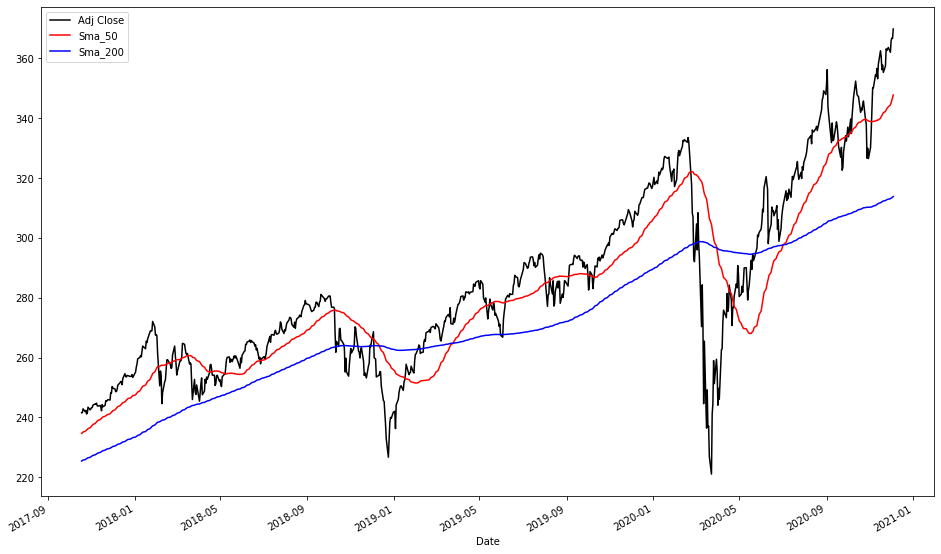

In [2]:
import matplotlib.pyplot as plt
df.plot(y=["Adj Close"]+shortTermMasCols+longTermMasCols,
        figsize=(16, 10),
        color=['k']+['r' for col in shortTermMasCols]+['b' for col in longTermMasCols]);